In [59]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score

In [79]:
dateTimeCols=['open_datetime','response_datetime','resolved_datetime','close_datetime']

cateFeatures=['product_type','brand','incident_type','service_type','is_failure_type','sla']
numericFeatures=['count_detail','open_to_close_hour','response_to_resolved_hour','open_to_response_hour','resolved_to_close_hour']

colLabel='severity_label'

colFeatures=cateFeatures+numericFeatures
cols=[colLabel]+colFeatures
print(cols)


isAutomaticOneHotByColumnTransformer=True
isManualEncoding=False
 


to_date='2023-12-31'

['severity_label', 'product_type', 'brand', 'incident_type', 'service_type', 'is_failure_type', 'sla', 'count_detail', 'open_to_close_hour', 'response_to_resolved_hour', 'open_to_response_hour', 'resolved_to_close_hour']


# Load and Prepare Data

In [80]:
df_incident = pd.read_csv('incident_data.csv',parse_dates=dateTimeCols)
print(f"Incident From {df_incident['open_datetime'].min()} To {df_incident['open_datetime'].max()}")
df_incident=df_incident.query("open_datetime<=@to_date")
df_incident=df_incident[cols]
print(df_incident.info())
df_incident.tail()



Incident From 2020-03-15 13:36:00 To 2023-02-01 06:40:00
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2095
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_label             2096 non-null   object 
 1   product_type               2096 non-null   object 
 2   brand                      2096 non-null   object 
 3   incident_type              2096 non-null   object 
 4   service_type               2096 non-null   object 
 5   is_failure_type            2096 non-null   bool   
 6   sla                        2096 non-null   object 
 7   count_detail               2096 non-null   int64  
 8   open_to_close_hour         2095 non-null   float64
 9   response_to_resolved_hour  2095 non-null   float64
 10  open_to_response_hour      2096 non-null   float64
 11  resolved_to_close_hour     2094 non-null   float64
dtypes: bool(1), float64(4), int64(1), object(6)
mem

,severity_label,product_type,brand,incident_type,service_type,is_failure_type,sla,count_detail,open_to_close_hour,response_to_resolved_hour,open_to_response_hour,resolved_to_close_hour
2091,Minor,Storage,YIP,General Incident,Request,False,24x7 6Hrs Resolution Time,1,67.250000,0.000000,67.250000,0.000000
2092,Major,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,3,365.316667,169.016667,2.633333,193.666667
2093,Major,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,2,20.166667,4.533333,0.550000,15.083333
2094,Major,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,1,23.783333,0.000000,23.783333,0.000000
2095,Major,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,2,31.150000,28.466667,1.450000,1.233333


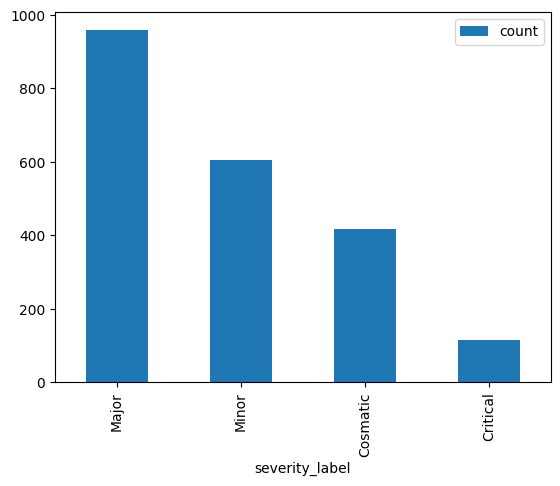

,count
severity_label,
Major,959
Minor,606
Cosmatic,417
Critical,114


In [81]:
dfLabel=df_incident.groupby([colLabel]).size().to_frame('count').sort_values(by='count',ascending=False)
dfLabel.plot(kind='bar')
plt.show()
dfLabel

# Process features and class

In [82]:
# cate_features=[ col for col in features if  col not in numericFeatures ]
if isAutomaticOneHotByColumnTransformer==False:
    
    if isManualEncoding==False:
        print("Let XGBoost encode itself")
    else:
        print("Encode by  LabelEncoder")
    features=[ col for col in list(df_incident.columns) if  col!=colLabel ]
    X = df_incident.loc[:,features]
    for cate_col in cateFeatures:
        if isManualEncoding==False:
              X[cate_col]=X[cate_col].astype("category")             
        else:  
            cateFeatEncoder = LabelEncoder()
            X[cate_col]=cateFeatEncoder.fit_transform(X[cate_col])

else:
        categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        ct = ColumnTransformer(transformers=[("cat", categorical_transformer,cateFeatures )],remainder='passthrough')
        ct.set_output(transform='pandas')
        X = ct.fit_transform(df_incident)
        colLabel=f"remainder__{colLabel}"
        print(f"{colLabel} :OneHot Encoding to Fetures by ColumnTransformer")
        


remainder__severity_label :OneHot Encoding to Fetures by ColumnTransformer


In [83]:
print(X.info())
X.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2095
Data columns (total 67 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   cat__product_type_Access Point              2096 non-null   float64
 1   cat__product_type_Firewall                  2096 non-null   float64
 2   cat__product_type_Hardware                  2096 non-null   float64
 3   cat__product_type_Other                     2096 non-null   float64
 4   cat__product_type_Security                  2096 non-null   float64
 5   cat__product_type_Server                    2096 non-null   float64
 6   cat__product_type_Software                  2096 non-null   float64
 7   cat__product_type_Storage                   2096 non-null   float64
 8   cat__product_type_Switch                    2096 non-null   float64
 9   cat__product_type_Tape Library              2096 non-null   float64
 10  cat__brand_B

,cat__product_type_Access Point,cat__product_type_Firewall,cat__product_type_Hardware,cat__product_type_Other,cat__product_type_Security,cat__product_type_Server,cat__product_type_Software,cat__product_type_Storage,cat__product_type_Switch,cat__product_type_Tape Library,...,cat__sla_24x7 6Hrs Resolution Time,cat__sla_24x7 6Hrs Response Time,cat__sla_8x5 4Hrs Response Time,cat__sla_9x5xNBD 4Hrs Response Time,remainder__severity_label,remainder__count_detail,remainder__open_to_close_hour,remainder__response_to_resolved_hour,remainder__open_to_response_hour,remainder__resolved_to_close_hour
2091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,Minor,1,67.250000,0.000000,67.250000,0.000000
2092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Major,3,365.316667,169.016667,2.633333,193.666667
2093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Major,2,20.166667,4.533333,0.550000,15.083333
2094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Major,1,23.783333,0.000000,23.783333,0.000000
2095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,Major,2,31.150000,28.466667,1.450000,1.233333


In [84]:
if isAutomaticOneHotByColumnTransformer==False:
    Y = df_incident.loc[:,[colLabel]]
    Y[colLabel]=Y[colLabel].astype("category")

    
else:
    Y=X.pop(colLabel)
    # # X=X.pop(colLabel)
    # Y[colLabel]=Y[colLabel].astype("category")

    print(Y.info())
Y[:5]

<class 'pandas.core.series.Series'>
Int64Index: 2096 entries, 0 to 2095
Series name: remainder__severity_label
Non-Null Count  Dtype 
--------------  ----- 
2096 non-null   object
dtypes: object(1)
memory usage: 32.8+ KB
None


0    Major
1    Major
2    Major
3    Minor
4    Major
Name: remainder__severity_label, dtype: object

# Encode string class values as integers

In [85]:
label_encoder = LabelEncoder()
ylabelEncoded = label_encoder.fit_transform(Y)

print(label_encoder.classes_)

print(ylabelEncoded[-5:])

['Cosmatic' 'Critical' 'Major' 'Minor']
[3 2 2 2 2]


# Split Train and Test Data

In [86]:
seed = 7
test_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(X, ylabelEncoded, test_size=test_size, random_state=seed)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)
print(y_train[:2])
X_train[:2]



#kfold = KFold(n_splits=5, random_state=seed,shuffle=True)
# kfold = StratifiedKFold(n_splits=10, random_state=seed,shuffle=True)


(1781, 66) (315, 66)
(1781,) (315,)
[3 0]


,cat__product_type_Access Point,cat__product_type_Firewall,cat__product_type_Hardware,cat__product_type_Other,cat__product_type_Security,cat__product_type_Server,cat__product_type_Software,cat__product_type_Storage,cat__product_type_Switch,cat__product_type_Tape Library,...,cat__sla_24x7 4Hrs Response Time,cat__sla_24x7 6Hrs Resolution Time,cat__sla_24x7 6Hrs Response Time,cat__sla_8x5 4Hrs Response Time,cat__sla_9x5xNBD 4Hrs Response Time,remainder__count_detail,remainder__open_to_close_hour,remainder__response_to_resolved_hour,remainder__open_to_response_hour,remainder__resolved_to_close_hour
2023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1,2.316667,0.166667,0.150000,2.0
841,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1,21.333333,2.800000,18.533333,0.0


# XGBoost Fit model no training data and Predict

In [87]:
# Supported tree methods are `gpu_hist`, `approx`, and `hist`.
if isManualEncoding==True or isAutomaticOneHotByColumnTransformer==True:
    print("XGBClassifier()")
    model_xg = XGBClassifier()
else:
   print("XGBClassifier(enable_categorical=True,tree_method=hist)")
   model_xg = XGBClassifier(enable_categorical=True,tree_method="hist")

# print(model_xg)

XGBClassifier()


In [88]:
# results = cross_val_score(model_xg, X, ylabelEncoded, cv=kfold)
# print(results) 
# print(f"Accuracy: {results.mean()*100} ({results.std()*100})")

model_xg.fit(X_train, y_train)

y_pred_xg = model_xg.predict(X_test)
predictions_xg = [round(value) for value in y_pred_xg]

accuracy_xg = accuracy_score(y_test, predictions_xg)
print("XGBoost Accuracy: %.2f%%" % (accuracy_xg * 100.0))

XGBoost Accuracy: 79.37%


# Feature Important

In [89]:
import matplotlib.pyplot  as plt
feature_series=pd.Series(model_xg.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_series

cat__service_type_Incident                  0.184560
cat__brand_NetApp                           0.041093
cat__brand_EMC                              0.030629
cat__incident_type_Network Cable Failure    0.029540
cat__incident_type_OS / Firmware            0.027906
                                              ...   
cat__sla_8x5 4Hrs Response Time             0.000000
cat__brand_Broadcom                         0.000000
cat__product_type_Tape Library              0.000000
cat__incident_type_Fan Failure              0.000000
cat__product_type_Security                  0.000000
Length: 66, dtype: float32

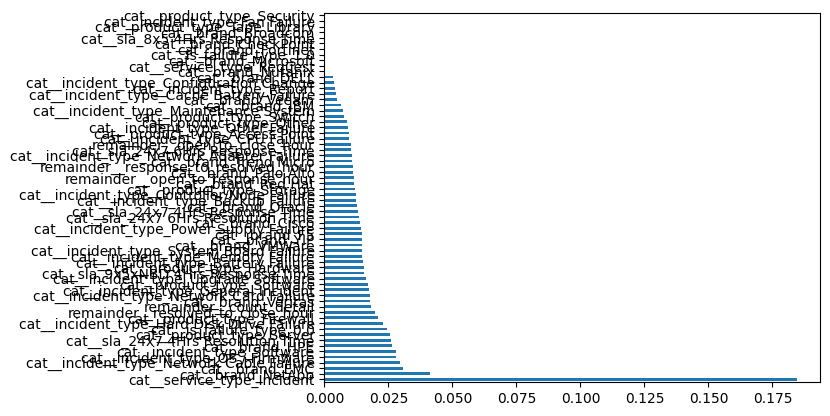

In [90]:
feature_series.plot(kind='barh')
plt.show()